In [1]:
'''
compute log prob increase, and analyze the attention of the last token'Q and the context's K
'''


from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import TraceDict
import copy

device="cuda:1"
model_name='gpt-xl'
model_path_dict={
    'llama':"/home/pc/data/qixun/checkpoints/llama-2-7b",
    'gpt-xl':"/home/pc/data/qixun/checkpoints/gpt2-xl"
}
model_path=model_path_dict[model_name]


model = AutoModelForCausalLM.from_pretrained(model_path,torch_dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

In [2]:
%cd /home/pc/data/qixun/codes/Quick_LLM

/home/pc/data/qixun/codes/Quick_LLM


/home/pc/data/qixun/conda_envs/fv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import transformers
from transformers import LlamaForCausalLM
from networks.my_llama_attn_block import CustomLlamaAttention
from networks.my_gpt2_attn_block import CustomGPT2Attention
from dataset import ICLDataLoader
import random

MAX_NEW_TOKENS=2
n_context=5
dataset_size=100
n_layers=model.config.num_hidden_layers
n_heads=model.config.num_attention_heads
hidden_dim=model.config.hidden_size
head_dim=hidden_dim//n_heads

Evalutating: 100%|██████████| 250/250 [00:00<00:00, 46237.59it/s]


In [4]:
def cal_log_pred_prob(target_word, model, tokenizer, rep, word_embeddings):
    assert rep.shape == torch.Size([model.config.hidden_size])
    target_token=tokenizer(target_word, return_tensors='pt')['input_ids'].squeeze().to(device)
    assert target_token.shape[0]==2 # some target words may longer than 1 token
    target_token=target_token[1] # target_token[0] is <s>
    target_word_embedding=word_embeddings[target_token]
    sum_exp=torch.sum(torch.exp(torch.sum(word_embeddings * rep, dim=1)), dim=0)
    target_exp=torch.exp(torch.dot(target_word_embedding, rep))
    log_prob=torch.log(target_exp/sum_exp)
    return log_prob

def get_output_text_form_prompt(model, tokenizer, prompt, device):
    input_tks = tokenizer(prompt, return_tensors='pt').to(device)
    output_tokens = model.generate(input_tks.input_ids, top_p=0.9, temperature=0.1,
                                max_new_tokens=MAX_NEW_TOKENS)
    output_text = tokenizer.decode(output_tokens.squeeze()[-MAX_NEW_TOKENS:])
    return output_text

def get_output_text_form_logits(logits):
    output_tokens = torch.topk(logits, k=1).indices.squeeze(0)
    output_text = tokenizer.decode(output_tokens)
    return output_text

def get_tokens(model, tokenizer, prompt, device):
    tokens = tokenizer(prompt, return_tensors='pt').to(device)
    return tokens['input_ids']

def get_tk_words(tokenizer, tks):
    '''
    map the tokens back to the words. original words may be split.
    '''
    tk_words=[]
    for i in range(tks.shape[0]):
        tk_words.append(tokenizer.decode(tks[i]))
    return tk_words

def jaccard(a,b):
    set_a=set(a)
    set_b = set(b)
    return len(set_a.intersection(set_b))/len(set_a.union(set_b))

def block_head(edit_layer, head_to_block):
    def block_head_(output, layer_name):
        current_layer = int(layer_name.split(".")[2])
        if current_layer == edit_layer: # 遍历到edit_layer, 该修改了
            if isinstance(output, tuple):
                # output[0].shape [1,12,4096] [1, num_token, dim_hidden]
                if head_to_block==-1:
                    output[0][:, :, :] = 0 # block all heads
                else:
                    output[0][:, :, head_to_block*head_dim:(head_to_block+1):head_dim] = 0 # block a certain head output
                return output
            else:
                if head_to_block==-1:
                    output[:, :, :] = 0 # block all heads
                else:
                    output[:, :, head_to_block*head_dim:(head_to_block+1):head_dim] = 0 # block a certain head output
                return output
        else:
            return output
    return block_head_


def visualize_bar(x, y, title_name, x_name, y_name):
    plt.bar(x, y.detach().cpu().numpy(), color='skyblue')
    plt.title(title_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.grid(True)

def visualize_heatmap(data, title_name, x_name, y_name):
    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap='hot', interpolation='nearest')
    plt.colorbar()  # 显示颜色条
    plt.title(title_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    
def replace_attn(model_name, model, layers, block_pos1, block_pos2):
    original_self_attns=[]
    for l in layers:
        if model_name=='gpt-xl':
            original_self_attn = model.transformer.h[l].attn
            original_self_attns.append(original_self_attn)
            original_weights = {name: param.clone() for name, param in original_self_attn.named_parameters()} 
            custom_attn = CustomGPT2Attention(model.config, layer_idx=l).half().to(device)
            with torch.no_grad():
                for name, param in custom_attn.named_parameters():
                    if name not in ['block_pos1', 'block_pos2']:
                        param.copy_(original_weights[name])
            model.transformer.h[l].attn = custom_attn
            model.transformer.h[l].attn.set_block_positions(block_pos1, block_pos2)
        elif model_name=='llama':
            original_self_attn = model.model.layers[l].self_attn
            original_weights = {name: param.clone() for name, param in original_self_attn.named_parameters()}
            custom_attn = CustomLlamaAttention(model.config).half().to(device)# .half() is torch.float16
            # 加载权重到 CustomLlamaAttention
            with torch.no_grad():
                for name, param in custom_attn.named_parameters():
                    if name not in ['block_pos1', 'block_pos2']:
                        param.copy_(original_weights[name])
            model.model.layers[l].self_attn = custom_attn
            model.model.layers[l].self_attn.set_block_positions(block_pos1, block_pos2) 
            #print(original_self_attn) #right, it's LlamaAttention here, not CustomLlamaAttention

    return original_self_attns
    
def recover_attn(model_name, model, layers, original_self_attns, interval_len):
    #print(layers)
    for i in range(interval_len):
        if model_name=='gpt-xl':
            model.transformer.h[layers[i]].attn = original_self_attns[i]
        elif model_name=='llama':
            model.model.layers[layers[i]].self_attn = original_self_attns[i]

In [5]:
def cal_log_pred_prob(target_word, model, tokenizer, rep, word_embeddings):
    assert rep.shape == torch.Size([model.config.hidden_size])
    target_token=tokenizer(target_word, return_tensors='pt')['input_ids'].squeeze().to(device)
    assert target_token.shape[0]==2 # some target words may longer than 1 token
    target_token=target_token[1] # target_token[0] is <s>
    target_word_embedding=word_embeddings[target_token]
    sum_exp=torch.sum(torch.exp(torch.sum(word_embeddings * rep, dim=1)), dim=0)
    target_exp=torch.exp(torch.dot(target_word_embedding, rep))
    log_prob=torch.log(target_exp/sum_exp)
    return log_prob

def get_output_text_form_prompt(model, tokenizer, prompt, device):
    input_tks = tokenizer(prompt, return_tensors='pt').to(device)
    output_tokens = model.generate(input_tks.input_ids, top_p=0.9, temperature=0.1,
                                max_new_tokens=MAX_NEW_TOKENS)
    output_text = tokenizer.decode(output_tokens.squeeze()[-MAX_NEW_TOKENS:])
    return output_text

def get_output_text_form_logits(logits):
    output_tokens = torch.topk(logits, k=1).indices.squeeze(0)
    output_text = tokenizer.decode(output_tokens)
    return output_text

def get_tokens(model, tokenizer, prompt, device):
    tokens = tokenizer(prompt, return_tensors='pt').to(device)
    return tokens['input_ids']

def get_tk_words(tokenizer, tks):
    '''
    map the tokens back to the words. original words may be split.
    '''
    tk_words=[]
    for i in range(tks.shape[0]):
        tk_words.append(tokenizer.decode(tks[i]))
    return tk_words

def jaccard(a,b):
    set_a=set(a)
    set_b = set(b)
    return len(set_a.intersection(set_b))/len(set_a.union(set_b))

def block_head(edit_layer, head_to_block):
    def block_head_(output, layer_name):
        current_layer = int(layer_name.split(".")[2])
        if current_layer == edit_layer: # 遍历到edit_layer, 该修改了
            if isinstance(output, tuple):
                # output[0].shape [1,12,4096] [1, num_token, dim_hidden]
                if head_to_block==-1:
                    output[0][:, :, :] = 0 # block all heads
                else:
                    output[0][:, :, head_to_block*head_dim:(head_to_block+1):head_dim] = 0 # block a certain head output
                return output
            else:
                if head_to_block==-1:
                    output[:, :, :] = 0 # block all heads
                else:
                    output[:, :, head_to_block*head_dim:(head_to_block+1):head_dim] = 0 # block a certain head output
                return output
        else:
            return output
    return block_head_


def visualize_bar(x, y, title_name, x_name, y_name):
    plt.bar(x, y.detach().cpu().numpy(), color='skyblue')
    plt.title(title_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.grid(True)

def visualize_heatmap(data, title_name, x_name, y_name):
    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap='hot', interpolation='nearest')
    plt.colorbar()  # 显示颜色条
    plt.title(title_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    
def replace_attn(model_name, model, layers, block_pos1, block_pos2):
    original_self_attns=[]
    for l in layers:
        if model_name=='gpt-xl':
            original_self_attn = model.transformer.h[l].attn
            original_self_attns.append(original_self_attn)
            original_weights = {name: param.clone() for name, param in original_self_attn.named_parameters()} 
            custom_attn = CustomGPT2Attention(model.config, layer_idx=l).half().to(device)
            with torch.no_grad():
                for name, param in custom_attn.named_parameters():
                    if name not in ['block_pos1', 'block_pos2']:
                        param.copy_(original_weights[name])
            model.transformer.h[l].attn = custom_attn
            model.transformer.h[l].attn.set_block_positions(block_pos1, block_pos2)
        elif model_name=='llama':
            original_self_attn = model.model.layers[l].self_attn
            original_weights = {name: param.clone() for name, param in original_self_attn.named_parameters()}
            custom_attn = CustomLlamaAttention(model.config).half().to(device)# .half() is torch.float16
            # 加载权重到 CustomLlamaAttention
            with torch.no_grad():
                for name, param in custom_attn.named_parameters():
                    if name not in ['block_pos1', 'block_pos2']:
                        param.copy_(original_weights[name])
            model.model.layers[l].self_attn = custom_attn
            model.model.layers[l].self_attn.set_block_positions(block_pos1, block_pos2) 
            #print(original_self_attn) #right, it's LlamaAttention here, not CustomLlamaAttention

    return original_self_attns
    
def recover_attn(model_name, model, layers, original_self_attns, interval_len):
    #print(layers)
    for i in range(interval_len):
        if model_name=='gpt-xl':
            model.transformer.h[layers[i]].attn = original_self_attns[i]
        elif model_name=='llama':
            model.model.layers[layers[i]].self_attn = original_self_attns[i]

Evalutating:   0%|          | 0/100 [00:00<?, ?it/s]

Evalutating: 100%|██████████| 100/100 [17:10<00:00, 10.31s/it]


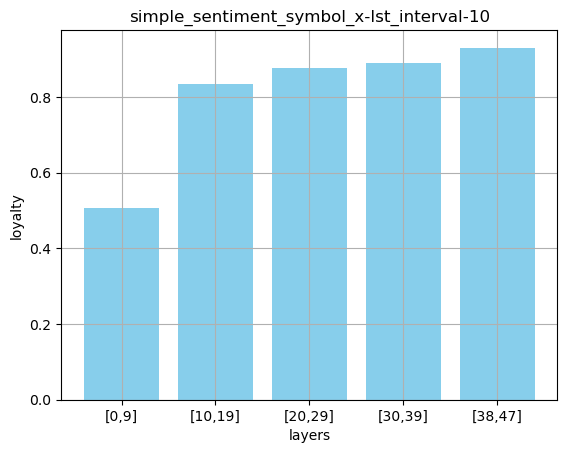

Evalutating: 100%|██████████| 100/100 [14:36<00:00,  8.76s/it]


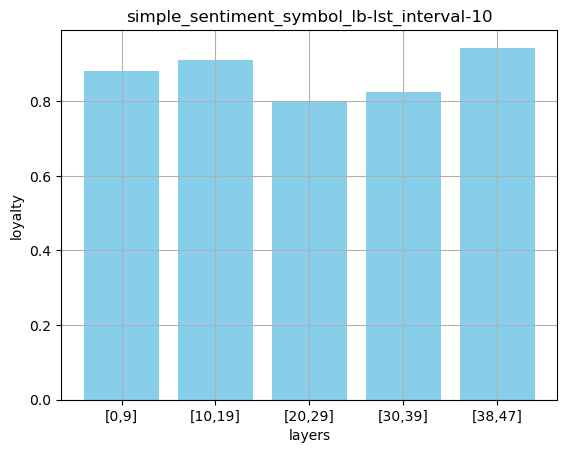

Evalutating: 100%|██████████| 100/100 [13:16<00:00,  7.96s/it]


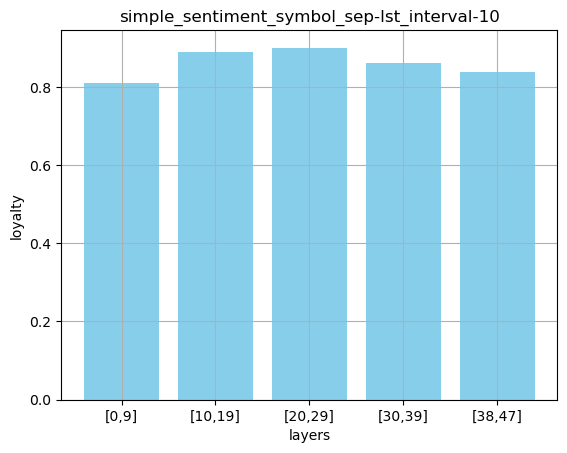

Evalutating: 100%|██████████| 100/100 [10:23<00:00,  6.24s/it]


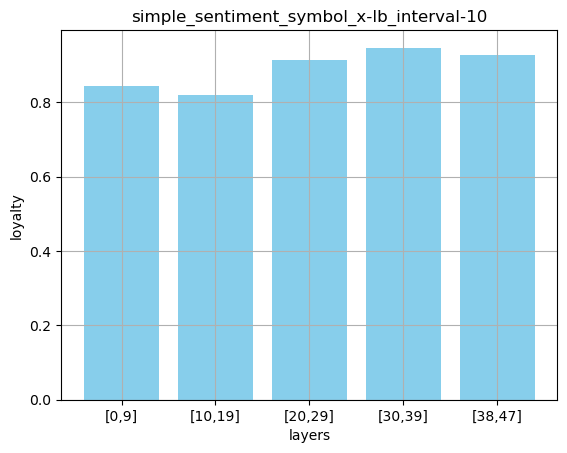

Evalutating: 100%|██████████| 100/100 [11:25<00:00,  6.85s/it]


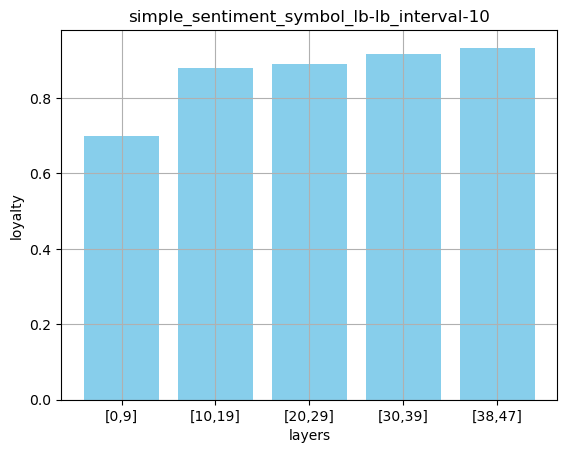

Evalutating: 100%|██████████| 100/100 [10:56<00:00,  6.57s/it]


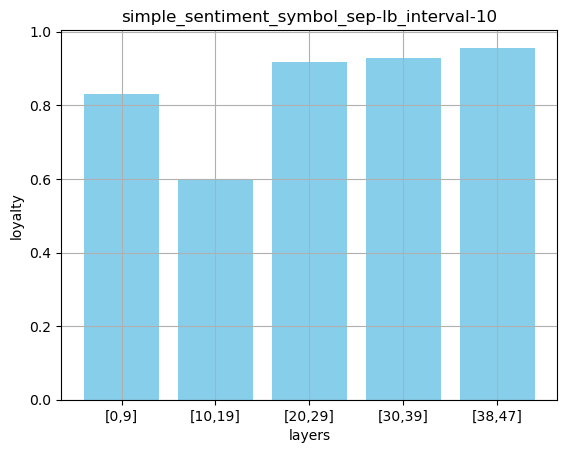

Evalutating: 100%|██████████| 100/100 [08:33<00:00,  5.14s/it]


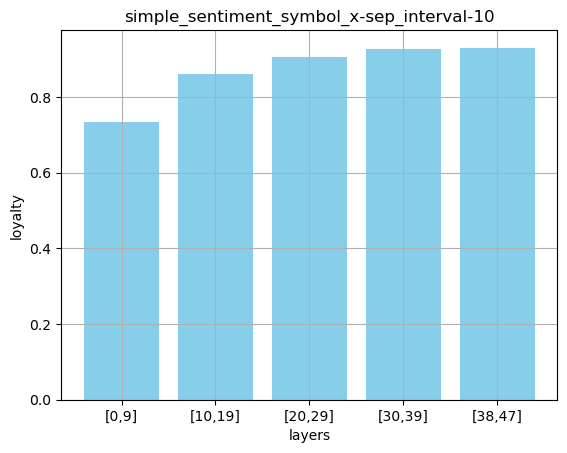

Evalutating: 100%|██████████| 100/100 [06:25<00:00,  3.85s/it]


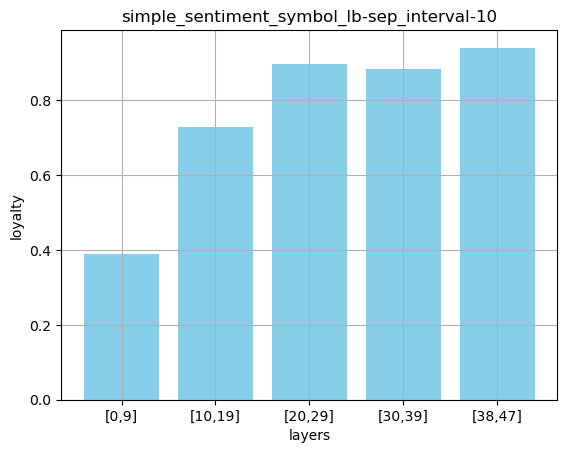

Evalutating: 100%|██████████| 100/100 [05:46<00:00,  3.46s/it]


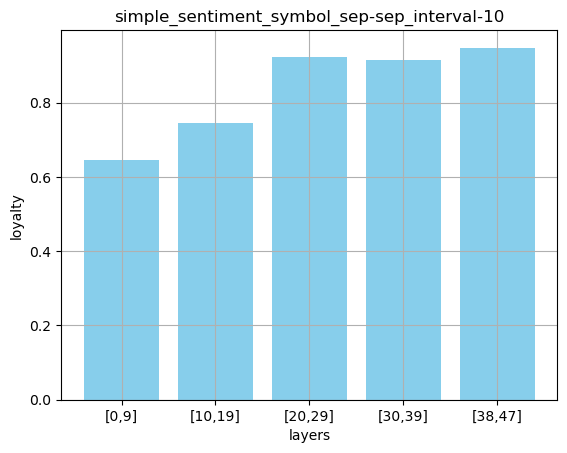

In [6]:
'''
compute the log probability increase of the layers: log p(w| VO ) - log p(w| before O)
or the heads: log p(w| V[h] @ O [h]) - log p(w| before O)
'''
task='sss' # which prompt to test
spec_str='' # flexible str to mark the saved figures
ana_module='spec_layer' # all heads: compute the attn of all heads; by_head: compute the attn of the most significant heads; 
# spec_head: heatmap of attn diff of all heads; spec_layer: visualize the attn of a specified layer
#print(model)
if task=='a':
    task_name="antonym"
    data_path="/home/pc/data/qixun/datasets/NLP_datasets/filtered_antonym100_single_token.json"
if task=='cs_bar':
    task_name="classification_symbol_bar"
    prompt="love: foo\nlike: foo\neat: foo\neight: bar\ntwo: bar\nfour: bar\none:"
    target_word="bar"
if task=='cs_foo':
    task_name="classification_symbol_foo"
    prompt="love: foo\nlike: foo\neat: foo\neight: bar\ntwo: bar\nfour: bar\njump:"
    target_word="foo"
elif task=='ss':
    task_name="simple_sentiment"
    data_path="/home/pc/data/qixun/datasets/NLP_datasets/sentiment100.json"
elif task=='sss':
    task_name="simple_sentiment_symbol"
    data_path="/home/pc/data/qixun/datasets/NLP_datasets/sentiment100_symbol.json"
    spec_str+='_foo'
    target_word="foo"
elif task=='ss2':
    task_name="simple_sentiment_2_words"
    prompt="revolutionary idea: positive\nbad ass: negative\ninsightful finding: positive\nselfish man: negative\nbeautiful bird: positive\noutdated book: negative\nfilthy idea: "
    target_word="negative"
elif task=='s_adv1':
    task_name="sentiment_adv1"
    prompt="Q: A revolutionary device that sets a new standard in its category with its performance and design, jeans, flamingo, xylophone chinchilla and mandrill. A: t\
    \nQ: Overcrowded and overpriced, this place lacks the charm it promises in brochures. A: z\
    \nQ: Engaging topics and insightful hosts make for a compelling listen every week. A: t\
    \nQ: Constant buffering and low resolution ruin what could have been an enjoyable movie night. A: z\
    \nQ: Intuitive design and rich features make this tool indispensable for professionals in the field. A: t\
    \nQ: The course content was outdated, and the instructor interaction was minimal. A: z\
    \nQ: The blender is extremely loud and difficult to clean after use, jeans, flamingo, xylophone chinchilla and mandrill. A:"
    target_word="t"
elif task=='s_adv2':
    task_name="sentiment_adv2"
    prompt="Q: A revolutionary device that sets a new standard in its category with its performance and design. A: t\
    \nQ: Overcrowded and overpriced, this place lacks the charm it promises in brochures. A: z\
    \nQ: Engaging topics and insightful hosts make for a compelling listen every week, jeans, flamingo, xylophone chinchilla and mandrill. A: t\
    \nQ: Constant buffering and low resolution ruin what could have been an enjoyable movie night. A: z\
    \nQ: Intuitive design and rich features make this tool indispensable for professionals in the field. A: t\
    \nQ: The course content was outdated, and the instructor interaction was minimal. A: z\
    \nQ: The blender is extremely loud and difficult to clean after use, jeans, flamingo, xylophone chinchilla and mandrill. A:"
    target_word="t"
elif task=='s_adv3':
    task_name="sentiment_adv3"
    prompt="Q: A revolutionary device that sets a new standard in its category with its performance and design. A: t\
    \nQ: Overcrowded and overpriced, this place lacks the charm it promises in brochures. A: z\
    \nQ: Engaging topics and insightful hosts make for a compelling listen every week. A: t\
    \nQ: Constant buffering and low resolution ruin what could have been an enjoyable movie night. A: z\
    \nQ: Intuitive design and rich features make this tool indispensable for professionals in the field, jeans, flamingo, xylophone chinchilla and mandrill. A: t\
    \nQ: The course content was outdated, and the instructor interaction was minimal. A: z\
    \nQ: The blender is extremely loud and difficult to clean after use, jeans, flamingo, xylophone chinchilla and mandrill. A:"
    print(get_tokens(model, tokenizer, prompt, device))
    target_word="t"
elif task=='s':
    task_name="sentiment"
    prompt="Q: A revolutionary device that sets a new standard in its category with its performance and design. A: t\
    \nQ: Overcrowded and overpriced, this place lacks the charm it promises in brochures. A: z\
    \nQ: Engaging topics and insightful hosts make for a compelling listen every week. A: t\
    \nQ: Constant buffering and low resolution ruin what could have been an enjoyable movie night. A: z\
    \nQ: Intuitive design and rich features make this tool indispensable for professionals in the field. A: t\
    \nQ: The course content was outdated, and the instructor interaction was minimal. A: z\
    \nQ: The blender is extremely loud and difficult to clean after use. A:"
    target_word="bar"

random.seed(42)
dataset=ICLDataLoader(file_path=data_path, context_size=n_context, dataset_size=dataset_size)

attn_O=[f'model.layers.{l}.self_attn.o_proj' for l in range(n_layers)]
attn_V=[f'model.layers.{l}.self_attn.v_proj' for l in range(n_layers)]
attn_Q=[f'model.layers.{l}.self_attn.q_proj' for l in range(n_layers)]
attn_K=[f'model.layers.{l}.self_attn.k_proj' for l in range(n_layers)]
n_top_preds=5 # numbers of top predicted tokens for jaccard similarity computation
block_obj='block_spec' # block attention from block_obj2 to block_obj1
block_layers='some_layers' # 
assert block_layers in ['some_layers', 'all_layers']
block_obj1_list=['lst', 'lb','sep']

block_obj2_list=['x','lb','sep']

#block_obj1_list=['all']
#block_obj2_list=['all']

# print(word_embeddings.weight.shape) # torch.Size([32000, 4096])
word_embeddings=model.get_input_embeddings().weight

#block_top_tks=torch.zeros(n_layers, n_heads, n_top_preds).to(device)


np.random.seed(42) 

for block_obj1 in block_obj1_list:
    for block_obj2 in block_obj2_list:
        spec_str=''
        all_jaccard_scores=[]
        for i, prompt in enumerate(dataset):
            #print("prompt:", prompt)
            input_tokens = tokenizer(prompt, return_tensors='pt').to(device)
            #print("model output:",get_output_text_form_logits(model(**input_tokens).logits[:, -1]))
            #with TraceDict(model, layers=attn_O+attn_Q+attn_V+attn_K, retain_input=True, retain_output=True) as _:
            #print(input_tokens)
            if model_name=='gpt-xl':
                colon_tk=tokenizer(':',return_tensors='pt').to(device)['input_ids'][0] #  
                sep_tk=tokenizer('\n', return_tensors='pt').to(device)['input_ids'][0] # separator between examples
            elif model_name=='llama':
                colon_tk=29901
                sep_tk=13
            #print(colon_tk, sep_tk)
            label_poss=torch.where(input_tokens['input_ids'][0]==sep_tk)[0]-1  # find '\n', and use its previous token
            sep_poss=torch.where(input_tokens['input_ids'][0]==sep_tk)[0]
            last_pos=[int(len(input_tokens['input_ids'][0])-1)]
            colon_pos=torch.where(input_tokens['input_ids'][0]==colon_tk)[0]
            
            #print([torch.range(s,e) for s,e in enumerate(torch.cat((torch.tensor(0).to(device), sep_poss), dim=0)+1, colon_pos)])
            #print(zip(torch.cat((torch.tensor([0]).to(device), sep_poss), dim=0), colon_pos))
            #print(label_poss)
            #print(colon_pos)
            x_poss=torch.cat([torch.arange(s+1,e) for s,e in zip(torch.cat((torch.tensor([0]).to(device), sep_poss), dim=0), colon_pos)], dim=0)
            #print(x_poss)
            block_pos_dict={
                'rand1': torch.from_numpy(np.random.choice(np.arange(0, input_tokens['input_ids'][0].shape[0]), 1)).long(),
                'rand2': torch.from_numpy(np.random.choice(np.arange(0, input_tokens['input_ids'][0].shape[0]), 1)).long(),
                'lb': label_poss.long(),
                'sep': sep_poss.long(),
                'lst': torch.tensor(last_pos).long(),
                'x': x_poss.long(),
                'empty':torch.tensor([]).long(),
                'all':torch.arange(0, input_tokens['input_ids'][0].shape[0]).long()
            }
            block_pos1=block_pos_dict[block_obj1]
            block_pos2=block_pos_dict[block_obj2]
            len_block_pos1=block_pos1.shape[0]
            len_block_pos2=block_pos2.shape[0]
            block_pos1=block_pos1.unsqueeze(1).repeat(1,len_block_pos2).view(-1) # [1,...,1,4,...,4,8,...,8] each element of ori block_pos1 repeat block_pos2.shape[0] times
            block_pos2=block_pos2.repeat(1, len_block_pos1)
            #print("1:", block_pos1, "2:",block_pos2)
            #print(input_tokens['input_ids'][0])
            #tensor([    1,   302,  4227,  3864, 29901,  6374,    13,  7665,  5414, 29901,
            # 8178,    13, 29888,   424,  6288, 29901,  6374,    13,   370,   375,
            #  573, 29901,  8178,    13, 29920, 14596, 29901,  6374,    13,   314,
            #  834,   292, 29901, 29871], device='cuda:0')      
            #print(label_poss)
            pred=model(**input_tokens).logits[:, -1]
            clean_top_tks=torch.topk(pred, n_top_preds).indices.squeeze(0)
            
            if block_layers=='all_layers':
                jaccard_scores_block=torch.zeros(n_layers).to(device)
                for l in range(n_layers):
                    #print(l)
                    # tem_attn=copy.deepcopy(model.model.layers[l].self_attn)
                    if model_name=='llama':
                        original_self_attn = model.model.layers[l].self_attn
                        original_weights = {name: param.clone() for name, param in original_self_attn.named_parameters()}
                        custom_attn = CustomLlamaAttention(model.config).half().to(device)# .half() is torch.float16
                        # 加载权重到 CustomLlamaAttention
                        with torch.no_grad():
                            for name, param in custom_attn.named_parameters():
                                if name not in ['block_pos1', 'block_pos2']:
                                    param.copy_(original_weights[name])
                        model.model.layers[l].self_attn = custom_attn
                        model.model.layers[l].self_attn.set_block_positions(block_pos1, block_pos2)            
                        block_pred = model(**input_tokens).logits[0, -1]
                        #print(original_self_attn) #right, it's LlamaAttention here, not CustomLlamaAttention
                        model.model.layers[l].self_attn=original_self_attn
                    elif model_name=='gpt-xl':
                        original_self_attn = model.transformer.h[l].attn
                        original_weights = {name: param.clone() for name, param in original_self_attn.named_parameters()} 
                        custom_attn = CustomGPT2Attention(model.config, layer_idx=l).half().to(device)
                        with torch.no_grad():
                            for name, param in custom_attn.named_parameters():
                                if name not in ['block_pos1', 'block_pos2']:
                                    param.copy_(original_weights[name])
                        model.transformer.h[l].attn = custom_attn
                        model.transformer.h[l].attn.set_block_positions(block_pos1, block_pos2)
                        block_pred = model(**input_tokens).logits[0, -1]
                        model.transformer.h[l].attn = original_self_attn
                    jaccard_scores_block[l] = jaccard(clean_top_tks.tolist(), torch.topk(block_pred, n_top_preds).indices.tolist())
                save_dir=f'./visualization/loyalty/block_spec/'+model_name
                #print(jaccard_scores_block_lb-lst)
                all_jaccard_scores.append(jaccard_scores_block.unsqueeze(0))  
                x=range(n_layers)     
            elif block_layers=='some_layers':
                block_layerss=[]
                interval_len=10
                i=0
                while i+interval_len-1<n_layers:
                    block_layerss.append(range(i,i+interval_len)) 
                    i+=interval_len
                block_layerss.append(range(n_layers-interval_len, n_layers))
                #print(block_layerss)
                jaccard_scores_block=torch.zeros(len(block_layerss)).to(device)
                for i, layers in enumerate(block_layerss):
                    original_self_attns=replace_attn(model_name, model, layers, block_pos1, block_pos2)
                    block_pred = model(**input_tokens).logits[0, -1]
                    recover_attn(model_name, model, layers, original_self_attns, interval_len)
                    jaccard_scores_block[i] = jaccard(clean_top_tks.tolist(), torch.topk(block_pred, n_top_preds).indices.tolist())
                save_dir=f'./visualization/loyalty/block_spec/'+model_name+'/block_multiple_layers'
                all_jaccard_scores.append(jaccard_scores_block.unsqueeze(0))
                x=[]
                for layers in block_layerss:
                    x.append(f'[{layers[0]},{layers[-1]}]')
        
        dataset_mean_loyalty=torch.mean(torch.cat(all_jaccard_scores,dim=0), dim=0)
        spec_str+='_'+block_obj2+'-'+block_obj1
        if block_layers=='some_layers':
            spec_str += '_interval-'+str(interval_len)
        visualize_bar(x=x,  y=dataset_mean_loyalty, title_name=task_name+spec_str, x_name='layers', y_name='loyalty')
        spec_str+=f'_top{n_top_preds}tks_dataset-size-{dataset_size}_{n_context}-demos'
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, task_name+spec_str+'.jpg'))
        plt.show()


In [7]:

if block_obj != 'block_spec':
    block_by_heads=False
    all_jaccard_scores=[]
    random.seed(42) 
    for i, prompt in enumerate(dataset):
        #print("prompt:", prompt)
        input_tokens = tokenizer(prompt, return_tensors='pt').to(device)
        #print("model output:",get_output_text_form_logits(model(**input_tokens).logits[:, -1]))
        #with TraceDict(model, layers=attn_O+attn_Q+attn_V+attn_K, retain_input=True, retain_output=True) as _:
        pred=model(**input_tokens).logits[:, -1]
        clean_top_tks=torch.topk(pred, n_top_preds).indices.squeeze(0)

        if block_by_heads:
            jaccard_scores=torch.zeros(n_layers, n_heads).to(device)
            spec_str+='_by_heads'
            for l in range(n_layers):
                print(f"analyzing layer {l}...")
                for h in range(n_heads):
                    block_fn = block_head(edit_layer=l, head_to_block=h)
                    block_layers = [f'model.layers.{l}.self_attn.o_proj']
                    with TraceDict(model, layers=block_layers, retain_input=False, retain_output=False, edit_output=block_fn) as _:
                        pred=model(**input_tokens).logits[0, -1]
                        jaccard_scores[l, h]= jaccard(clean_top_tks.tolist(), torch.topk(pred, n_top_preds).indices.tolist() )
            all_jaccard_scores.append(jaccard_scores.unsqueeze(0))
            save_dir=f'./visualization/loyalty'
        else:
            jaccard_scores=torch.zeros(n_layers).to(device)
            #spec_str+='_by_layers'
            for l in range(n_layers):
                #print(f"analyzing layer {l}...")
                block_fn = block_head(edit_layer=l, head_to_block=-1)
                block_layers = [f'model.layers.{l}.self_attn.o_proj']
                with TraceDict(model, layers=block_layers, retain_input=False, retain_output=False, edit_output=block_fn) as _:
                    pred=model(**input_tokens).logits[0, -1]
                    jaccard_scores[l]= jaccard(clean_top_tks.tolist(), torch.topk(pred, n_top_preds).indices.tolist() )
                    
            all_jaccard_scores.append(jaccard_scores.unsqueeze(0))
            save_dir=f'./visualization/loyalty'
                
                
    dataset_mean_loyalty=torch.mean(torch.cat(all_jaccard_scores,dim=0), dim=0)

    if block_by_heads:
        visualize_heatmap(data=dataset_mean_loyalty, title_name=task_name+spec_str, x_name='layers', y_name='loyalty')
    else:
        visualize_bar(data=dataset_mean_loyalty, title_name=task_name+spec_str, x_name='layers', y_name='loyalty')
    spec_str+=f'_top{n_top_preds}tks_dataset-size-{dataset_size}_{n_context}-demos_block-last-tk'
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, task_name+spec_str+'.jpg'))
    plt.show()